In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib ipympl
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import math
import statistics

In [2]:
# Read in the .csv file that contains the data
med_rec = pd.read_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/MR/Data/medical_clean.csv")

In [3]:
# Check for missing values
med_rec.isnull().sum().sum()

0

In [4]:
# Drop columns that contain individual indentification that isn't necessary to the model
# and rename vague column names to be more descriptive.
med_rec = med_rec.drop(['CaseOrder','Customer_id','Interaction','UID', 'City','County','Zip','State', 'TimeZone','Lat','Lng','Job'], axis=1)
med_rec = med_rec.rename({'Item1':'Timely_admission','Item2':'Timely_treatment','Item3':'Timely_visits','Item4':'Reliability',
               'Item5':'Options','Item6':'Hours_treatment','Item7':'Courteous','Item8':'Active_listening'}, axis='columns')

In [5]:
# Convert No/Yes to 0/1 in binary variables
boo = ['ReAdmis','Soft_drink','HighBlood','Stroke','Overweight','Arthritis','Diabetes','Hyperlipidemia',
       'BackPain','Anxiety','Allergic_rhinitis','Reflux_esophagitis','Asthma']
med_rec[boo] = med_rec[boo].replace({'No':False, 'Yes':True})

In [6]:
# Convert data types to category as appropriate to make analysis easier
cat = ['Area','Marital','Gender','Initial_admin','Complication_risk','Services']
med_rec[cat] = med_rec[cat].astype('category')

In [7]:
# Summary statistics for catigorical variables
med_rec.describe(include=['category'])

,Area,Marital,Gender,Initial_admin,Complication_risk,Services
count,10000,10000,10000,10000,10000,10000
unique,3,5,3,3,3,4
top,Rural,Widowed,Female,Emergency Admission,Medium,Blood Work
freq,3369,2045,5018,5060,4517,5265


In [9]:
# Summary statistics for discrete and
# ordinal variables of the data type int64
med_rec.describe(include=['int64'])

,Population,Children,Age,Doc_visits,Full_meals_eaten,vitD_supp,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_treatment,Courteous,Active_listening
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9965.253800,2.097200,53.511700,5.012200,1.001400,0.398900,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,14824.758614,2.163659,20.638538,1.045734,1.008117,0.628505,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,694.750000,0.000000,36.000000,4.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,2769.000000,1.000000,53.000000,5.000000,1.000000,0.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,13945.000000,3.000000,71.000000,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,122814.000000,10.000000,89.000000,9.000000,7.000000,5.000000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [10]:
# Summary statistics for the continous variables 
med_rec.describe(include=['float64'])

,Income,VitD_levels,Initial_days,TotalCharge,Additional_charges
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,40490.495160,17.964262,34.455299,5312.172769,12934.528587
std,28521.153293,2.017231,26.309341,2180.393838,6542.601544
min,154.080000,9.806483,1.001981,1938.312067,3125.703000
25%,19598.775000,16.626439,7.896215,3179.374015,7986.487755
50%,33768.420000,17.951122,35.836244,5213.952000,11573.977735
75%,54296.402500,19.347963,61.161020,7459.699750,15626.490000
max,207249.100000,26.394449,71.981490,9180.728000,30566.070000


In [11]:
# Summary statistics for binary variables 
# to include the response variable
med_rec.describe(include=['bool'])

,ReAdmis,Soft_drink,HighBlood,Stroke,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,True,False,False,False,False,False,False,False,False
freq,6331,7425,5910,8007,7094,6426,7262,6628,5886,6785,6059,5865,7107


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5

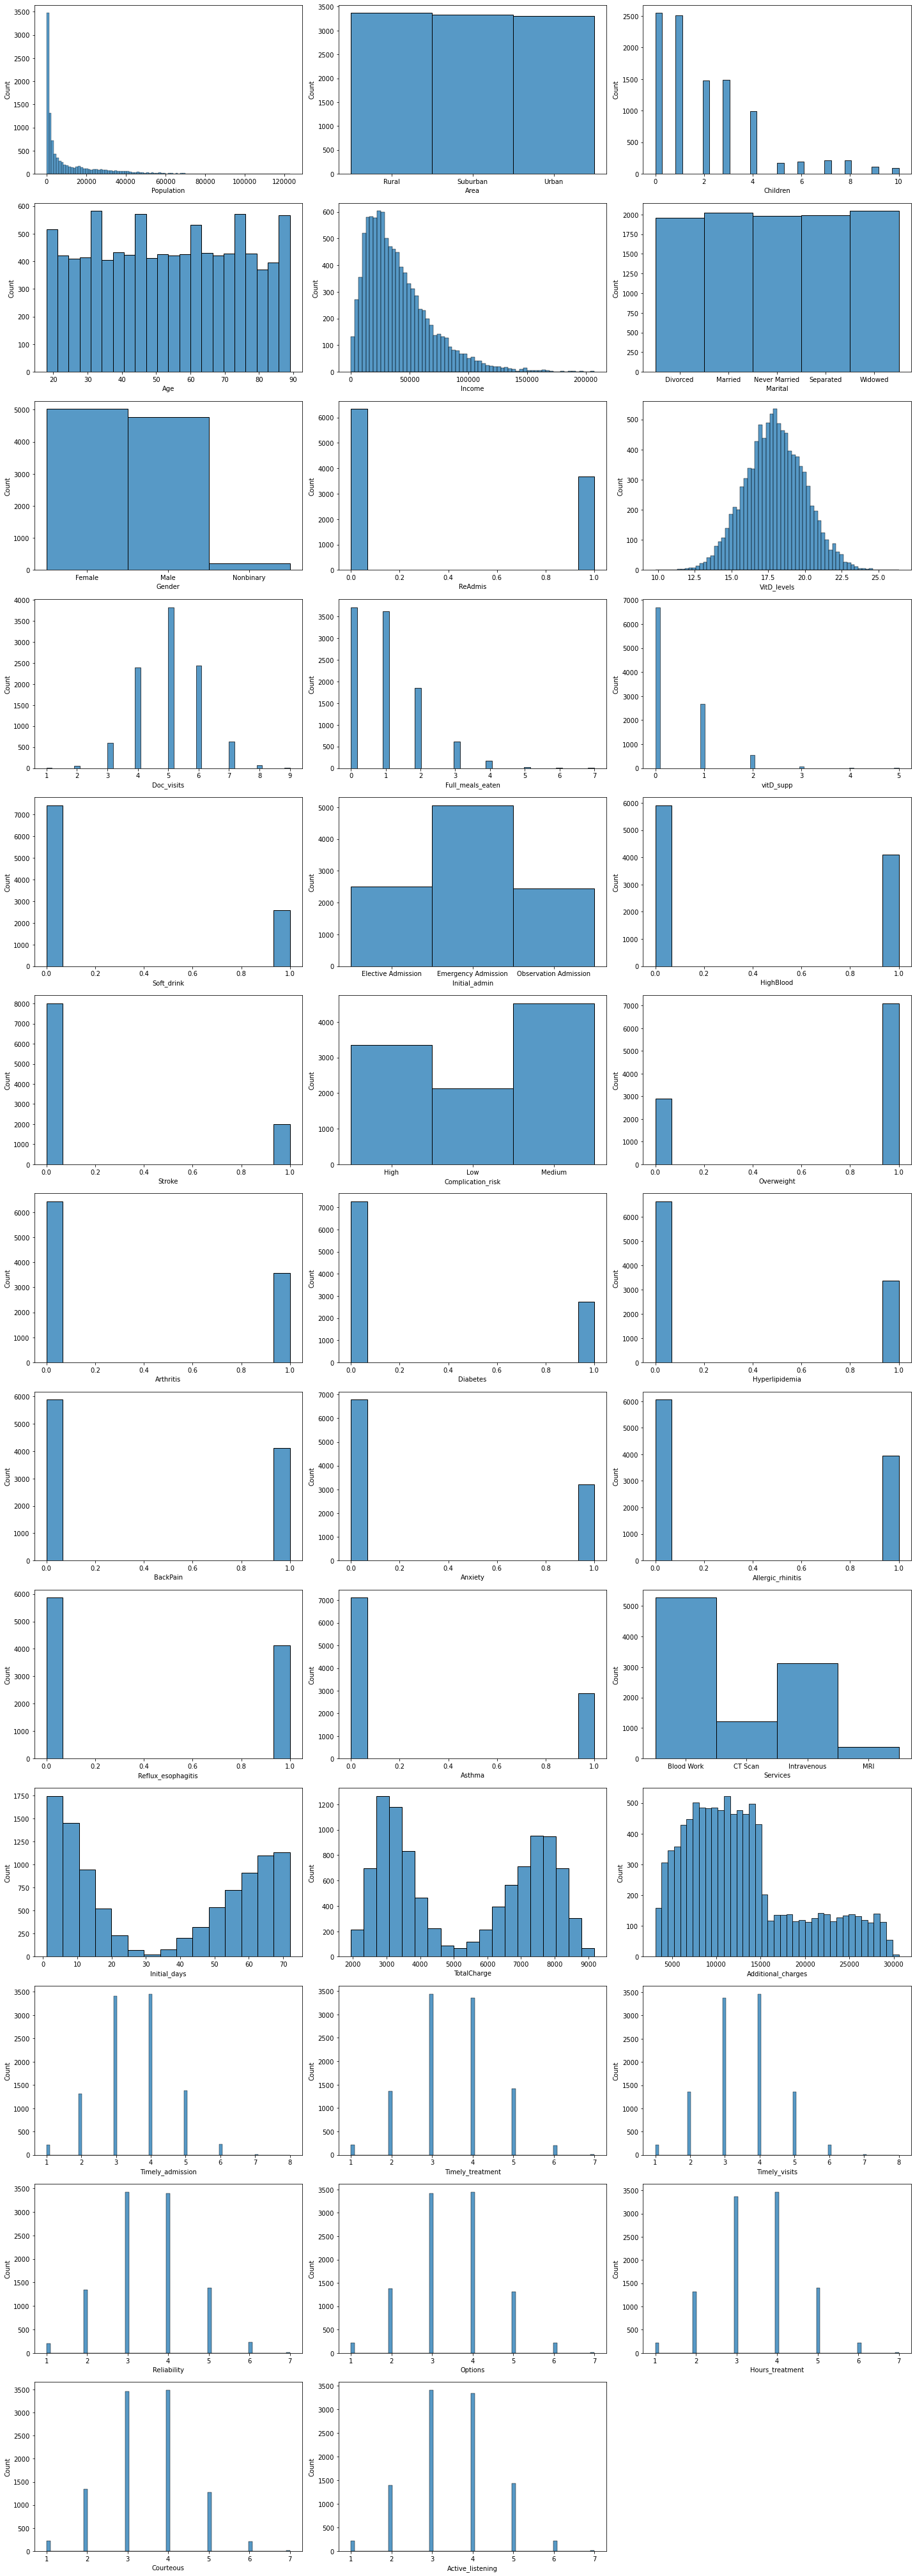

In [12]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(20,60))
col_max=14
row_max=3
fig_dims = (col_max,row_max)

# For loop that iterates over every variable producing a graph
i = 0
j = 0
for col, row in med_rec.iteritems():
    plt.subplot2grid(fig_dims,(i, j))
    sns.histplot(x=med_rec[col], multiple='dodge')
    j+=1
    if (j == row_max):
        j=0
        i+=1
    if (i == col_max):
        break
# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5

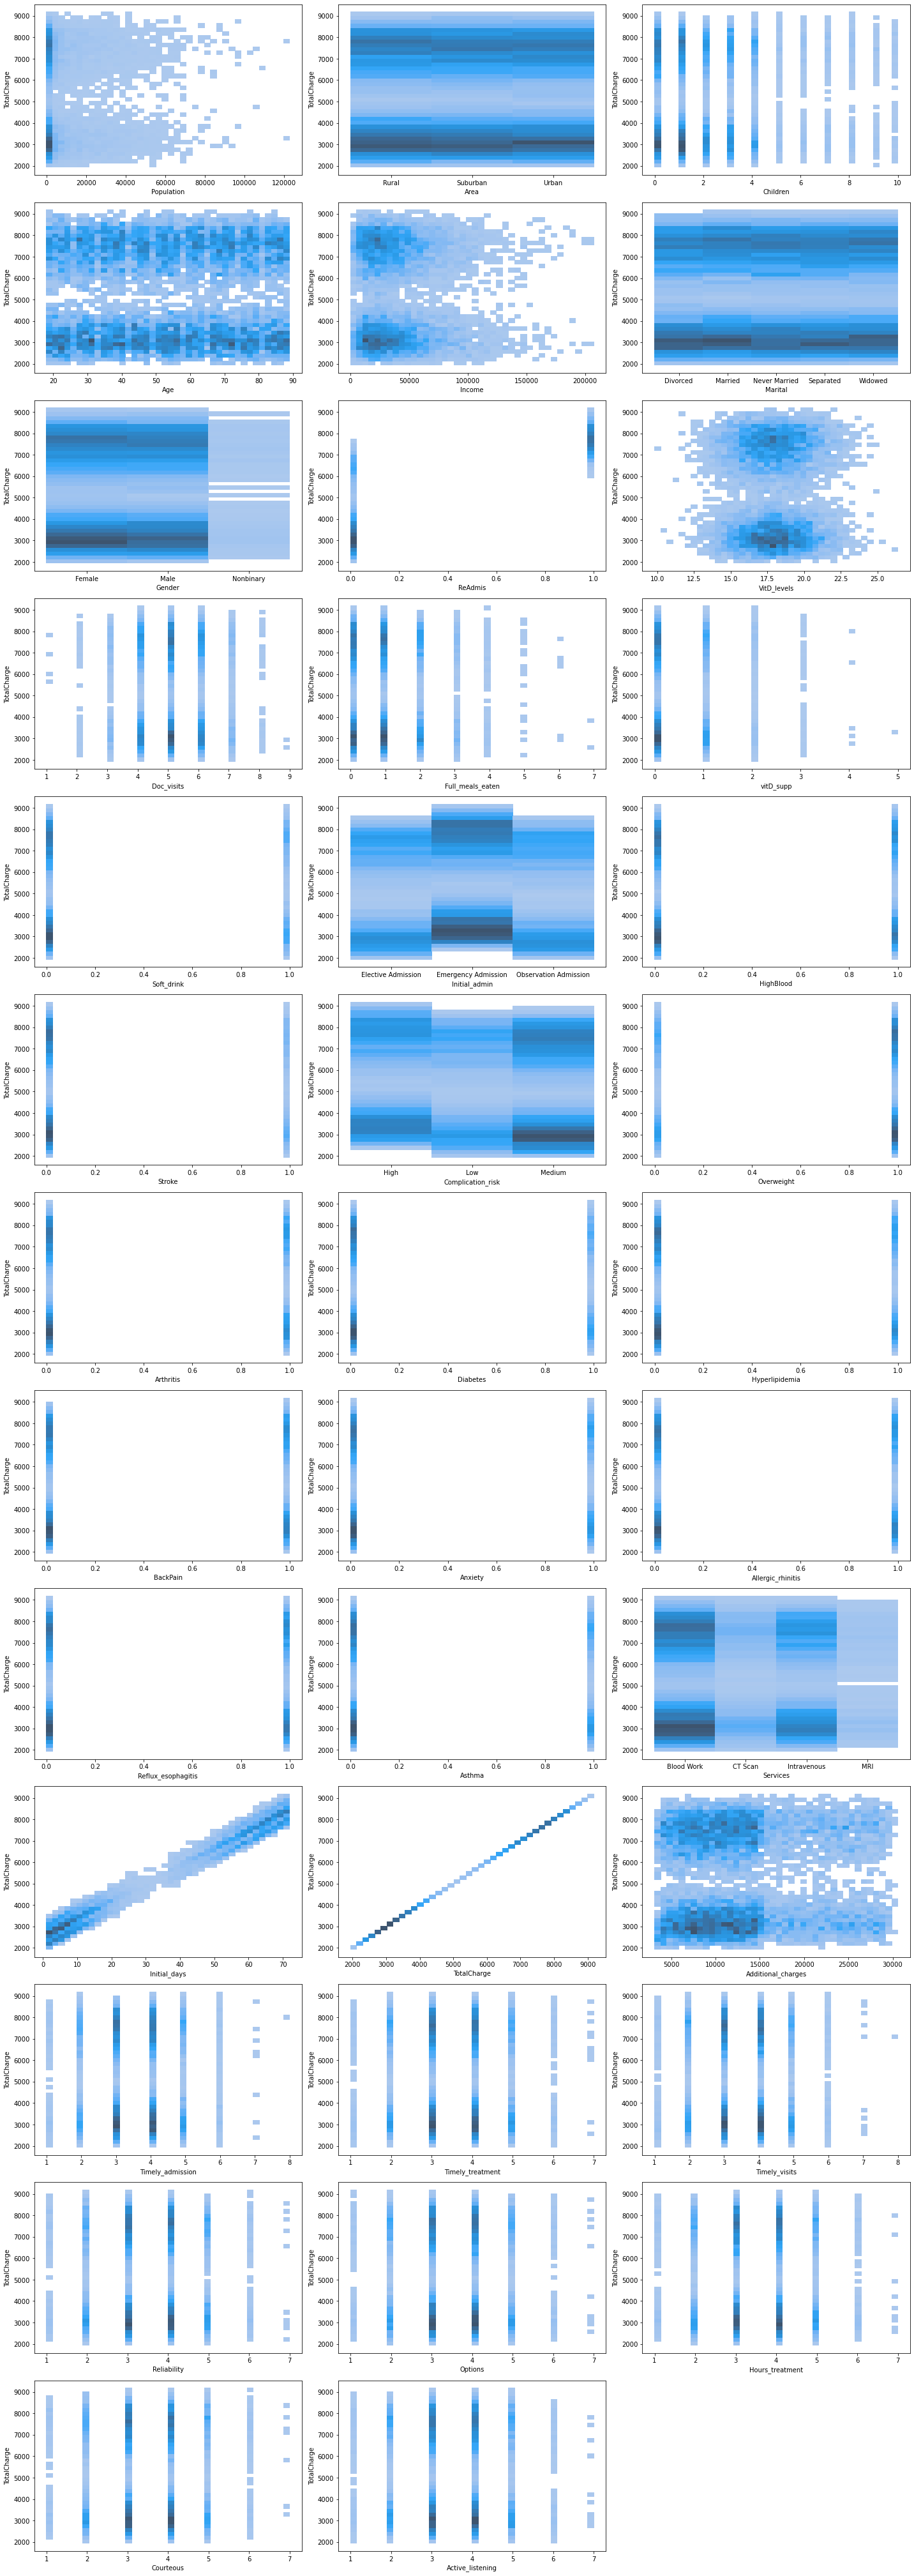

In [13]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(20,60))
col_max=14
row_max=3
fig_dims = (col_max,row_max)

# For loop that iterates over every independent variable producing a graph
# that is split on the dependent variable.
i = 0
j = 0
for col, row in med_rec.iteritems():
    plt.subplot2grid(fig_dims,(i, j))
    sns.histplot(data=med_rec, x=med_rec[col], y=med_rec.TotalCharge, legend=False, bins=40)
    j+=1
    if (j == row_max):
        j=0
        i+=1
    if (i == col_max):
        break
# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

In [14]:
# Create Dummy Variables for all categorical independent variables
med_rec_dummies=pd.get_dummies(med_rec, drop_first=True)

In [15]:
# Split the data into dependent and independent variables
dependent = med_rec_dummies.TotalCharge
independent = med_rec_dummies.drop(columns=['TotalCharge'])
independent = sm.add_constant(independent)

In [16]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = independent.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(independent.astype(float).values, i)
                          for i in range(len(independent.columns))]

In [17]:
# Creates a list of independent variables that have excessive
# VIF numbers, then drops them from the data
feature_list = []
for feature, VIF in zip(vif_data.feature, vif_data.VIF):
    if VIF > 5 and feature != 'const':
        print("Variable: ",feature," VIF: ",VIF)
        feature_list.append(feature)
for item in feature_list:
    if item in independent:
        independent = independent.drop(columns=item)

Variable:  Age  VIF:  9.285170093623902
Variable:  HighBlood  VIF:  7.87257339132548
Variable:  Additional_charges  VIF:  16.325647750955838


In [18]:
# Write the prepared data to csv file
med_rec_prepared = med_rec.drop(['Age','HighBlood','Additional_charges'],axis='columns')
med_rec.to_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/MR/Data/medical_prepared.csv",index=False)

In [19]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.3)

In [20]:
# Create the model and print the summary
model = sm.OLS(y_train, x_train.astype(float))
result = model.fit(disp=0)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.545e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:31:06   Log-Likelihood:                -37985.
No. Observations:                7000   AIC:                         7.606e+04
Df Residuals:                    6956   BIC:                         7.636e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [21]:
# Creates a list of predictions
yhat = result.predict(x_test)

# Root Mean Squared Error (RMSE)
rmse = math.sqrt(metrics.mean_squared_error(y_test, yhat))
adj_rmse = rmse/(statistics.mean(y_test))

# prints the RMSE and RMSE as a percentage of
# the mean of observations
print('RMSE: ', rmse)
print('Adjust RMSE: ', adj_rmse)

RMSE:  55.43926501040018
Adjust RMSE:  0.010458763545072336


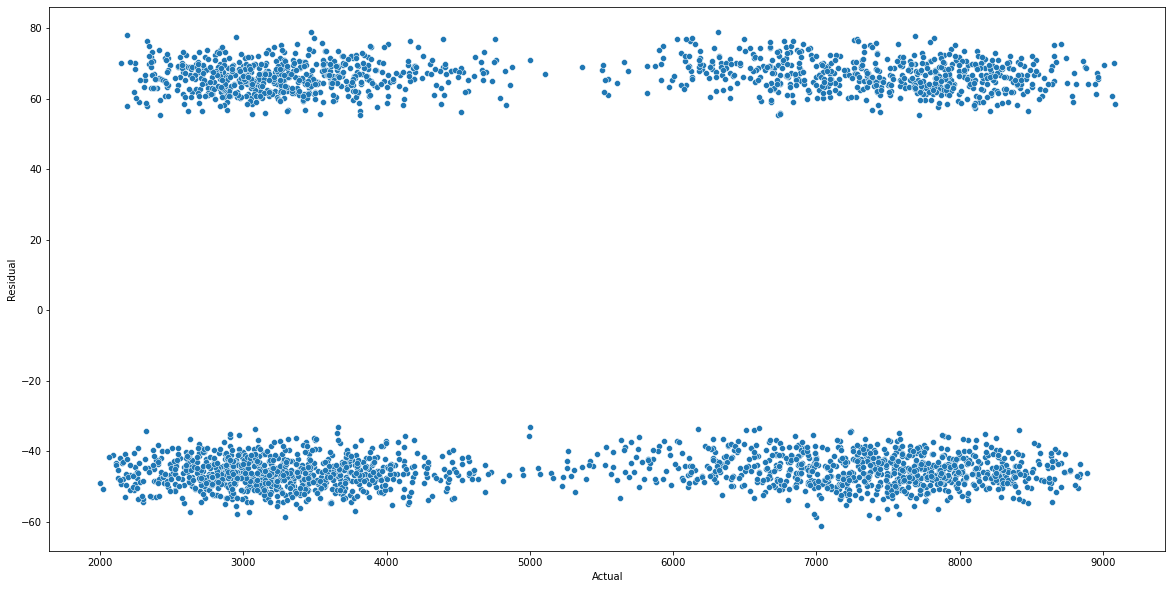

In [22]:
# Creates a scatterplot of the residuals along the
# regression line
fig = plt.figure(figsize=(20,10))
res = pd.DataFrame()
res['Residual'] = y_test-yhat
res['Actual'] = y_test
sns.scatterplot(data=res,y='Residual', x='Actual')
plt.show()

In [23]:
# Global variables to perfrom checks
sig_features = []
highest = 'no'
last_highest = 'yes'
adj_check = independent
current_adj = result.rsquared_adj


# Removes features with the highest p-values, then evaluates the Adjust R-Squared
# in order to determine if the feature helped predictability
elim_result = sm.OLS(dependent, independent.astype(float)).fit(disp=0)
min_adj = elim_result.rsquared_adj
while highest != last_highest:
    max_pvalue = 0.05
    last_highest = highest
    
    if min_adj < current_adj and highest != 'no':
        min_adj = current_adj
        adj_check = adj_check.drop(columns=highest)
    elif min_adj > current_adj and highest != 'no':
        sig_features.append(highest)
        independent = adj_check
    
    for feature, pvalue in zip(independent.columns, elim_result.pvalues):
        if pvalue > max_pvalue and feature not in sig_features:
            max_pvalue = pvalue
            highest = feature
    if highest != last_highest:
        independent = independent.drop(columns=highest)
        elim_result = sm.OLS(dependent, independent.astype(float)).fit(disp=0)
        current_adj = elim_result.rsquared_adj

In [24]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.3)

In [25]:
# Create the model and print the summary
model = sm.OLS(y_train, x_train.astype(float))
result = model.fit(disp=0)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.380e+05
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:34:17   Log-Likelihood:                -37999.
No. Observations:                7000   AIC:                         7.605e+04
Df Residuals:                    6974   BIC:                         7.623e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [26]:
# Creates a list of predictions
yhat = result.predict(x_test)

# Root Mean Squared Error (RMSE)
rmse = math.sqrt(metrics.mean_squared_error(y_test, yhat))
adj_rmse = rmse/(statistics.mean(y_test))

# prints the RMSE and RMSE as a percentage of
# the mean of observations
print('RMSE: ', rmse)
print('Adjust RMSE: ', adj_rmse)

RMSE:  55.14416224921068
Adjust RMSE:  0.010495486966801965


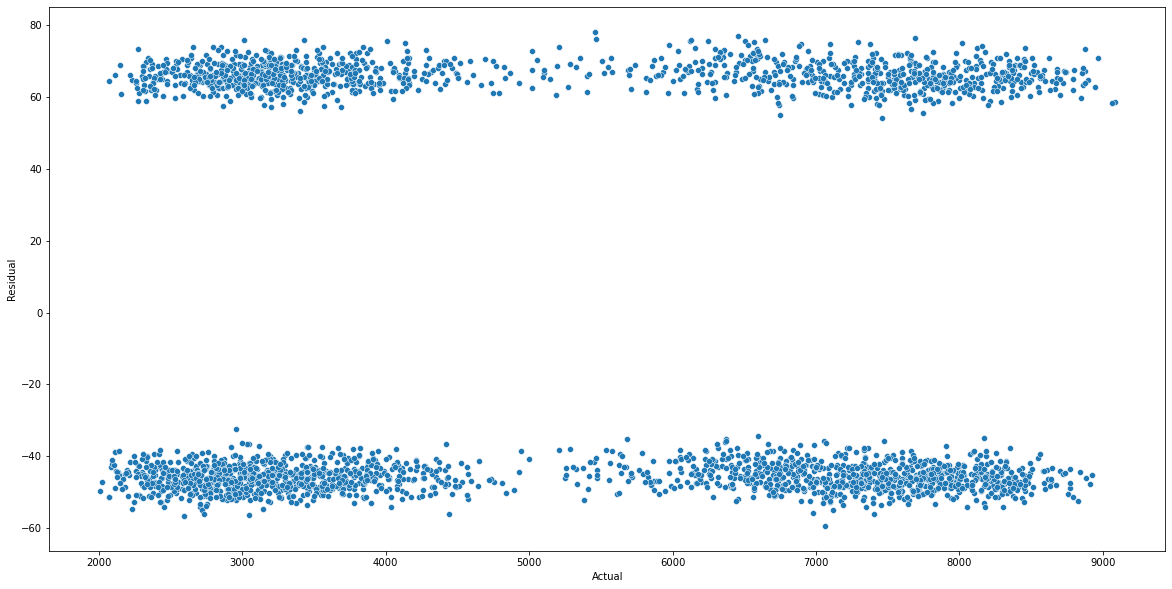

In [27]:
# Creates a scatterplot of the residuals along the
# regression line
fig = plt.figure(figsize=(20,10))
res = pd.DataFrame()
res['Residual'] = y_test-yhat
res['Actual'] = y_test
sns.scatterplot(data=res,y='Residual', x='Actual')
plt.show()

In [28]:
pred_act = pd.DataFrame()
pred_act['Prediction'] = yhat
pred_act['Actual'] = y_test
pred_act.head(10)

,Prediction,Actual
365,3098.732943,3171.543626
2217,3085.849177,3036.313136
6847,7864.886234,7926.822000
9442,7577.744386,7538.065000
2959,3738.790344,3691.018483
2320,4097.815965,4161.797085
5068,7243.639033,7310.160000
2956,2470.247718,2427.100055
1862,2595.008635,2553.439926
4065,2399.050923,2351.899114


In [29]:
result.params

const                                2321.450091
ReAdmis                                 3.431398
Full_meals_eaten                        1.077297
Overweight                              3.321131
Arthritis                              72.485213
Diabetes                               75.263822
Hyperlipidemia                         92.794129
BackPain                               85.881191
Anxiety                                86.587914
Allergic_rhinitis                      62.525736
Reflux_esophagitis                     60.591756
Initial_days                           81.883506
Timely_visits                          -1.257115
Reliability                            -0.694060
Options                                -1.225211
Courteous                               0.429882
Area_Suburban                           1.608538
Area_Urban                              0.221463
Marital_Never Married                  -1.970209
Marital_Separated                      -2.412678
Marital_Widowed     

In [30]:
# Collect the final independent variables, and the dependent variable together and
# Write the final cleaned data to a csv file
med_final = med_rec[['ReAdmis','Full_meals_eaten','Overweight','Arthritis','Diabetes','Hyperlipidemia', 'BackPain',
                     'Anxiety','Allergic_rhinitis','Reflux_esophagitis','Initial_days','Timely_visits','Reliability',
                     'Options','Courteous','Area','Marital','Gender','Initial_admin','Complication_risk','Services']]

med_final.to_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/MR/Data/medical_final.csv",index=False)